In [33]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# get data
train_data = datasets.FashionMNIST(root="../data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="../data", train=False, download=True, transform=ToTensor())

# get generator
batch_size = 64
train_batcher = DataLoader(train_data, batch_size=batch_size)
test_batcher = DataLoader(test_data, batch_size=batch_size)

In [37]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of labels: {len(train_data.classes)}")

for X, y in test_batcher:
    print(f"Shape of X: {X.shape} -> [batch size, color channels, img height, img width]")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Number of training images: 60000
Number of labels: 10
Shape of X: torch.Size([64, 1, 28, 28]) -> [batch size, color channels, img height, img width]
Shape of y: torch.Size([64]) torch.int64


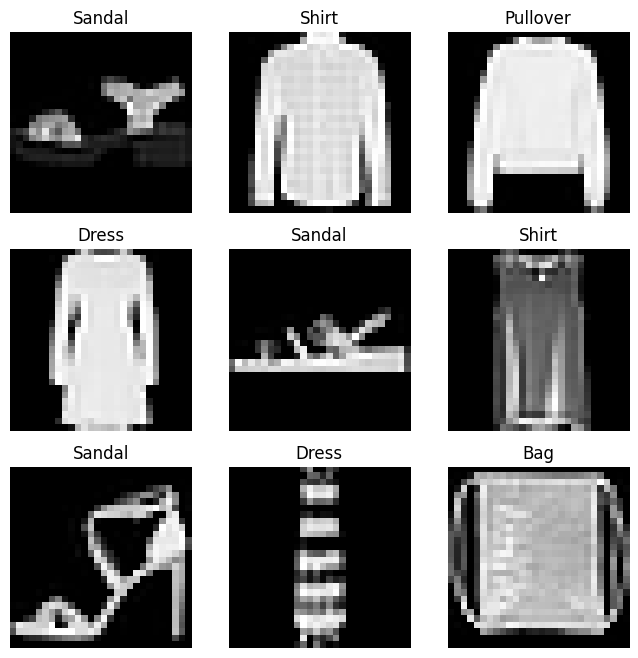

In [29]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[idx] # type: ignore
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # get prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# get generator
batch_size = 64
train_batcher = DataLoader(train_data, batch_size=batch_size)
test_batcher = DataLoader(test_data, batch_size=batch_size)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_batcher, model, loss_fn, optimizer)
    test(test_batcher, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Loss: 2.296888  [   64/60000]
Loss: 2.285763  [ 6464/60000]
Loss: 2.269067  [12864/60000]
Loss: 2.258817  [19264/60000]
Loss: 2.238209  [25664/60000]
Loss: 2.205789  [32064/60000]
Loss: 2.212168  [38464/60000]
Loss: 2.176340  [44864/60000]
Loss: 2.170627  [51264/60000]
Loss: 2.137077  [57664/60000]
Test Error: 
 Accuracy: 49.9%, Avg loss: 2.134259 

Epoch 2
-------------------------------
Loss: 2.150503  [   64/60000]
Loss: 2.130626  [ 6464/60000]
Loss: 2.076796  [12864/60000]
Loss: 2.088538  [19264/60000]
Loss: 2.029152  [25664/60000]
Loss: 1.969353  [32064/60000]
Loss: 1.985669  [38464/60000]
Loss: 1.909829  [44864/60000]
Loss: 1.917620  [51264/60000]
Loss: 1.832288  [57664/60000]
Test Error: 
 Accuracy: 57.4%, Avg loss: 1.839060 

Epoch 3
-------------------------------
Loss: 1.882246  [   64/60000]
Loss: 1.838282  [ 6464/60000]
Loss: 1.727350  [12864/60000]
Loss: 1.763102  [19264/60000]
Loss: 1.653013  [25664/60000]
Loss: 1.608614  [32064/600